<a href="https://colab.research.google.com/github/saivardhan4694/cancer-app/blob/main/Kidney_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as op
op.download("https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: makkapatimrk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone


100%|██████████| 1.52G/1.52G [00:06<00:00, 233MB/s]


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(
    "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 12446 files [00:03, 4049.10 files/s]


In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.0,
     rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range = 0.2,
     vertical_flip=True,
     horizontal_flip = True,
    fill_mode="reflect"
)


train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 64,)

val_datagen = ImageDataGenerator(rescale = 1/255.0)


val_generator = train_datagen.flow_from_directory(
     './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 64,)

Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        if lr > 0.0001:
            lr *= 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

callbacks = [lr_scheduler_callback]


In [ ]:
from tensorflow.keras.layers import Layer, Conv2D, Concatenate, Multiply
import tensorflow as tf

class spatial_attention(Layer):
    def __init__(self):
        super(spatial_attention, self).__init__()

        self.conv2d = Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")

    def call(self, inputs):
        x1 = tf.reduce_mean(inputs, axis=-1)
        x1 = tf.expand_dims(x1, axis=-1)

        x2 = tf.reduce_max(inputs, axis=-1)
        x2 = tf.expand_dims(x2, axis=-1)

        feats = Concatenate()([x1, x2])
        feats = self.conv2d(feats)
        feats = Multiply()([inputs, feats])

        return feats

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)))
model.add(spatial_attention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(spatial_attention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(spatial_attention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(spatial_attention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(spatial_attention())
model.add(GlobalAveragePooling2D())


model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 spatial_attention (spatial  (None, 224, 224, 32)      19        
 _attention)                                                     
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    batch_size = 128,
    epochs = 30,
    validation_data = val_generator, callbacks=callbacks)

Epoch 1/30
137/137 [==============================] - 328s 2s/step - loss: 12.4625 - accuracy: 0.6419 - val_loss: 8.0843 - val_accuracy: 0.1185 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - 323s 2s/step - loss: 5.0012 - accuracy: 0.7536 - val_loss: 4.8946 - val_accuracy: 0.1105 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - 323s 2s/step - loss: 2.5430 - accuracy: 0.7815 - val_loss: 4.0787 - val_accuracy: 0.2954 - lr: 0.0010
Epoch 4/30
137/137 [==============================] - 323s 2s/step - loss: 1.5430 - accuracy: 0.8206 - val_loss: 5.6192 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 5/30
137/137 [==============================] - 324s 2s/step - loss: 1.1619 - accuracy: 0.8261 - val_loss: 1.9146 - val_accuracy: 0.4225 - lr: 0.0010
Epoch 6/30
137/137 [==============================] - 324s 2s/step - loss: 0.9853 - accuracy: 0.8413 - val_loss: 2.9071 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 7/30
137/137 [==============================] - 324s 2s/s

In [ ]:
model.save('kidney_prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model(r"/content/kidney_prediction.h5", custom_objects={'spatial_attention': spatial_attention})

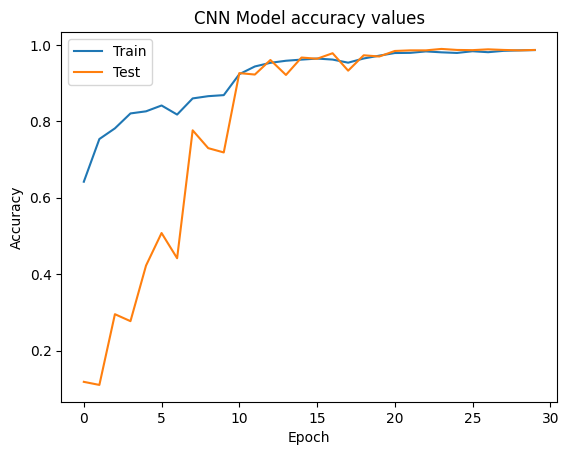

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

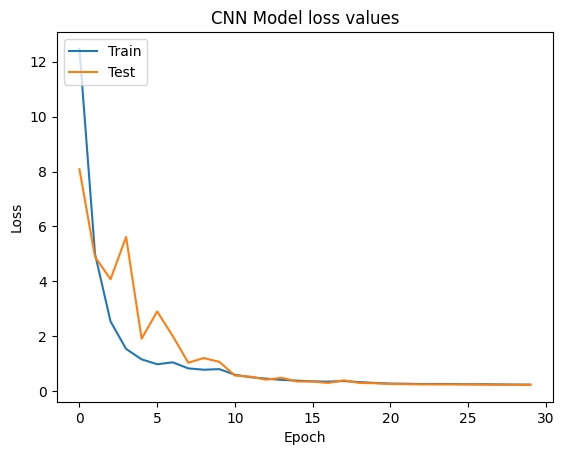

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1/255.0)


test_generator = train_datagen.flow_from_directory(
     './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 64,shuffle = False)

Found 1871 images belonging to 4 classes.


In [ ]:
pred = model.predict_generator(test_generator)

<ipython-input-19-f79076686fd5>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator)


In [ ]:
model.evaluate_generator(test_generator)

<ipython-input-20-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.22958144545555115, 0.9909139275550842]

In [ ]:
import  numpy as np
y_pred = np.argmax(pred, axis = 1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[555,   0,   2,   0],
       [  0, 759,   0,   4],
       [  8,   0, 200,   0],
       [  5,   3,   0, 335]])

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       557
           1       1.00      0.99      1.00       763
           2       0.99      0.96      0.98       208
           3       0.99      0.98      0.98       343

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871



<Axes: >

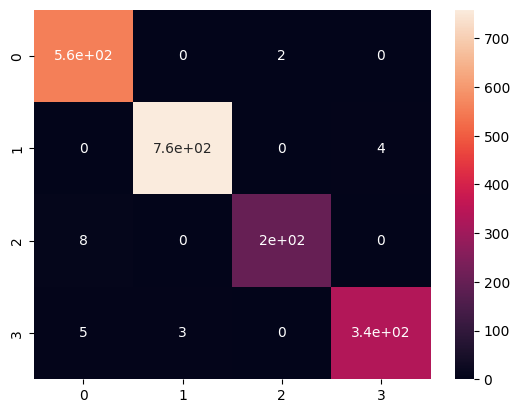

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot = True)